# Setup

In [ ]:
# imports 
from google.colab import drive 
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import pickle 
from nltk import ngrams

Setup Mounting Google Drive 

1. Mount Google Drive
2. Move datasets into local storage 
3. Unmount Google Drive

In [ ]:
# mount google drive 
drive.mount('content')

# copy file to local storage
trainSrcFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/train.csv'
testSrcFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/test.csv'
trainTargetFilePath = '/content/train.csv'
testTargetFilePath = '/content/test.csv'
shutil.copy(trainSrcFilePath, trainTargetFilePath)
shutil.copy(testSrcFilePath, testTargetFilePath)
# drive.flush_and_unmount()

Mounted at content


'/content/test.csv'

In [ ]:
# read in data to dataframs 
trainData = pd.read_csv('train.csv')
testData = pd.read_csv('test.csv')

In [ ]:
trainData.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation




---

---

---







# Simple Cleaning Training Data

In [ ]:
# dataframe.apply function 
def cleanTweets(tweet):
  return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])', ' ', tweet.lower()).split())

In [ ]:
trainData['clean_tweets'] = trainData['tweet'].apply(cleanTweets)
trainData.head()

,id,label,tweet,clean_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation




---



---



---



# Exploratory Analysis of Training Data

In [ ]:
# check shape of dataframe
trainData.shape

(31962, 4)

In [ ]:
# peak at training data 
trainData.head()

,id,label,tweet,clean_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [ ]:
# check for any null/missing values in the data 
trainData.isnull().sum()

id              0
label           0
tweet           0
clean_tweets    0
dtype: int64

In [ ]:
# check if there are any duplicated data entries in the data
trainData.duplicated().value_counts()

False    31962
dtype: int64

In [ ]:
# check the data splits between the labelled data 
trainData['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Text(0.5, 1.0, 'Label Counts')

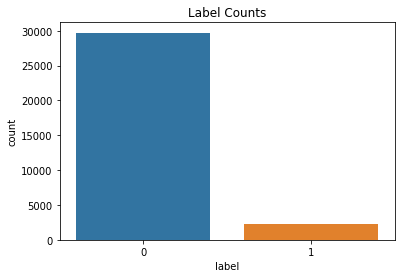

In [ ]:
# visualize label skew in data 
fig1 = sns.countplot(x = 'label', data = trainData)
plt.title('Label Counts')

Data is HIGHLY imbalanced. Will have to fix before training models.

In [ ]:
# hate tweets  
hateTweetsDF = trainData[trainData.label == 1]

# peak at hate tweets
hateTweetsDF.head()

,id,label,tweet,clean_tweets
13,14,1,@user #cnn calls #michigan middle school 'buil...,cnn calls michigan middle school build the wal...
14,15,1,no comment! in #australia #opkillingbay #se...,no comment in australia opkillingbay seashephe...
17,18,1,retweet if you agree!,retweet if you agree
23,24,1,@user @user lumpy says i am a . prove it lumpy.,lumpy says i am a prove it lumpy
34,35,1,it's unbelievable that in the 21st century we'...,it s unbelievable that in the 21st century we ...


In [ ]:
# regular tweets
regTweetsDF = trainData[trainData.label == 0]

# peak at normal tweets 
regTweetsDF.head()

,id,label,tweet,clean_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation




---



---



---



# Non-Hate Tweets

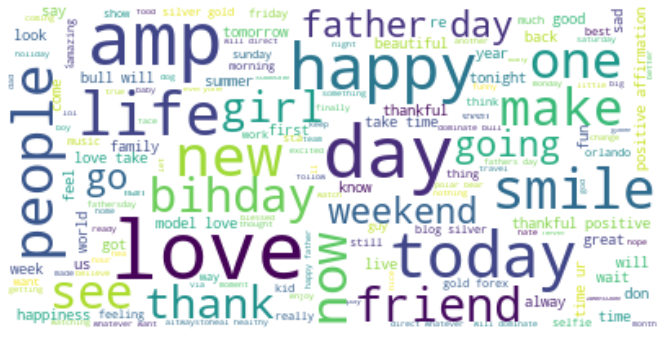

In [ ]:
regTweetsText = ' '.join(tweet for tweet in regTweetsDF.clean_tweets)
wordcloud = WordCloud(max_font_size = 50, max_words = 150, background_color = 'white').generate(regTweetsText)
fig = plt.figure(figsize = (20, 6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()



---



---



---



# Hate Tweets 

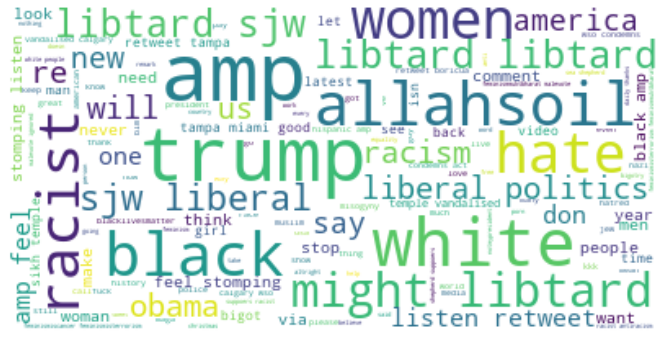

In [ ]:
hateTweetText = ' '.join(tweet for tweet in hateTweetsDF.clean_tweets)
wordcloud = WordCloud(max_font_size = 50, max_words = 150, background_color = 'white').generate(hateTweetText)
fig = plt.figure(figsize = (20, 6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()



---



---



---



# Two Sampling Methods 

## Oversampling to Fix Imbalance in Labels 

Need to fix the severe skew in the data between hate tweets and non-hate tweets. Random oversampling incolves randomly duplicating examples from the minority class (label = 1, hate tweets) and adding them to the training set. 

In [ ]:
# oversample minority class to balance the dataset 
regTweetsNum = trainData[trainData['label'] == 0]['clean_tweets'].count()
oversampledHateTweets = hateTweetsDF.sample(regTweetsNum, replace = True)
oversampledTrainDF = pd.concat([regTweetsDF, oversampledHateTweets], axis = 0)

# verify the label splits are equal now 
oversampledTrainDF['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [ ]:
# peak at the oversampled data 
oversampledTrainDF.head

<bound method NDFrame.head of           id  ...                                       clean_tweets
0          1  ...  when a father is dysfunctional and is so selfi...
1          2  ...  thanks for lyft credit i can t use cause they ...
2          3  ...                                bihday your majesty
3          4  ...      model i love u take with u all the time in ur
4          5  ...                  factsguide society now motivation
...      ...  ...                                                ...
28877  28878  ...  need a black page3 girl to shut down nomore pa...
21205  21206  ...  are black amp feel like the are stomping on yo...
27229  27230  ...  look at his latest tweet this conman doesn t w...
17621  17622  ...  that s harsh even in these post brexit xenopho...
1382    1383  ...  just because you liberals are self loathing do...

[59440 rows x 4 columns]>

## Undersampling to Fix Imbalance in Labels

Random undersampling involves randomly selecting examples from the majority class (label = 0, normal tweets) and deleting them from the training set. 

In [ ]:
# undersample majority class to balance the dataset 
hateTweetsNum = trainData[trainData['label'] == 1]['clean_tweets'].count()
undersampledRegTweets = regTweetsDF.sample(hateTweetsNum)
undersampledTrainDF = pd.concat([undersampledRegTweets, hateTweetsDF], axis = 0)

# verify the label splits are equal now 
undersampledTrainDF['label'].value_counts()

1    2242
0    2242
Name: label, dtype: int64

In [ ]:
# peak at undersampled data 
undersampledTrainDF.head()

,id,label,tweet,clean_tweets
21616,21617,0,"can't get rid of me that easy, lancaster. i'm ...",can t get rid of me that easy lancaster i m he...
29475,29476,0,cheers~ð¹#relextime #sunday #gathering #mo...,cheers relextime sunday gathering moments fath...
14793,14794,0,tcc is a company based in new zealand which pr...,tcc is a company based in new zealand which pr...
30638,30639,0,bard marocan teapot designed by elhabiba #ma...,bard marocan teapot designed by elhabiba maroc...
27972,27973,0,"@user what a fucking #joke ,..actually just ...",what a fucking joke actually just time soon to...




---



---



---



# Splitting Training Data

## Un-Sampled Data

In [ ]:
# split into train and test sets 
x = trainData['clean_tweets']
y = trainData['label']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 8)

## Oversampled Split

In [ ]:
# split into train and test sets 
oversampledX = oversampledTrainDF['clean_tweets']
oversampledY = oversampledTrainDF['label']

oX_train, oX_test, oY_train, oY_test = train_test_split(oversampledX, oversampledY, test_size = 0.2, random_state = 8)

## Undersampled Split

In [ ]:
# split into train and test sets 
undersampledX = undersampledTrainDF['clean_tweets']
undersampledY = undersampledTrainDF['label']

uX_train, uX_test, uY_train, uY_test = train_test_split(undersampledX, undersampledY, test_size = 0.2, random_state = 8)



---



---



---



# Vectorize Data and Calculate TF-IDF

In [ ]:
countVector = CountVectorizer(stop_words = 'english', ngram_range = (1, 3))
transformer = TfidfTransformer()

countVector1 = CountVectorizer(stop_words = 'english', ngram_range = (1, 3))
transformer1 = TfidfTransformer()

countVector2 = CountVectorizer(stop_words = 'english', ngram_range = (1, 3))
transformer2 = TfidfTransformer()

## Un-Sampled Data

In [ ]:
# get tf-idf info for un-sampled data 
xTrainCounts = countVector.fit_transform(x_train)
xTrainTFIDF = transformer.fit_transform(xTrainCounts)

print(xTrainCounts.shape)
print(xTrainTFIDF.shape)

(25569, 272839)
(25569, 272839)


In [ ]:
xTestCounts = countVector.transform(x_test)
xTestTFIDF = transformer.transform(xTestCounts)

print(xTestCounts.shape)
print(xTestTFIDF.shape)

(6393, 272839)
(6393, 272839)


In [ ]:
countVectorFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/CV and TFIDF/countVector.sav'
tfidfFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/CV and TFIDF/tfidf.sav'
pickle.dump(countVector, open(countVectorFilePath, 'wb'))
pickle.dump(transformer, open(tfidfFilePath, 'wb'))

## Oversampled Data

In [ ]:
# get tf-idf info for oversampled data 
oXTrainCounts = countVector1.fit_transform(oX_train)
oXTrainTFIDF = transformer1.fit_transform(oXTrainCounts)

print(oXTrainCounts.shape)
print(oXTrainTFIDF.shape)

(47552, 275652)
(47552, 275652)


In [ ]:
oXTestCounts = countVector1.transform(oX_test)
oXTestTFIDF = transformer1.transform(oXTestCounts)

print(oXTestCounts.shape)
print(oXTestTFIDF.shape)

(11888, 275652)
(11888, 275652)


In [ ]:
countVectorOversampledFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/CV and TFIDF/countVectorOversampled.sav'
tfidfOversampledFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/CV and TFIDF/tfidfOversampled.sav'
pickle.dump(countVector1, open(countVectorOversampledFilePath, 'wb'))
pickle.dump(transformer1, open(tfidfOversampledFilePath, 'wb'))

## Undersampled Data

In [ ]:
# get tf-idf info for undersampled data 
uXTrainCounts = countVector2.fit_transform(uX_train)
uXTrainTFIDF = transformer2.fit_transform(uXTrainCounts)

print(uXTrainCounts.shape)
print(uXTrainTFIDF.shape)

(3587, 46024)
(3587, 46024)


In [ ]:
uXTestCounts = countVector2.transform(uX_test)
uXTestTFIDF = transformer2.transform(uXTestCounts)

print(uXTestCounts.shape)
print(uXTestTFIDF.shape)

(897, 46024)
(897, 46024)


In [ ]:
countVectorUndersampledFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/CV and TFIDF/countVectorUndersampled.sav'
tfidfUndersampledFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/CV and TFIDF/tfidfUndersampled.sav'
pickle.dump(countVector2, open(countVectorUndersampledFilePath, 'wb'))
pickle.dump(transformer2, open(tfidfUndersampledFilePath, 'wb'))



---



---



---



# Random Forest Classifier

In [ ]:
# parameters to tune 
nEstimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 100)]
maxFeatures = ['auto', 'sqrt', 'log2']
minSamplesSplit = [2, 5, 10, 12, 15]

rfGrid = {'n_estimators': nEstimators, 'max_features': maxFeatures, 'min_samples_split': minSamplesSplit}

## Un-Sampled Data

In [ ]:
# model 
rFGridSearch = RandomForestClassifier()

# random search over the parameters, 3 fold CV, 5 iterations 
rFModel = RandomizedSearchCV(estimator = rFGridSearch, scoring = 'f1', param_distributions = rfGrid, n_iter = 5, cv = 3, verbose = 2, n_jobs = -1)
rFModel.fit(xTrainTFIDF, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 5, 10, 12, 15],
                                        'n_estimators': [500, 510, 520, 530,
                                                         540, 550, 560, 570,
                                                         580, 590, 601, 611,
                                                         621, 631, 641, 651,
                                                         661, 671, 681, 691,
                                                         702, 712, 722, 732,
                                                         742, 752, 762, 772,
                                                         782, 792, ...]},
                   scoring='f1', verbose=2)

In [ ]:
# best parameters 
rFModel.best_params_ 

# LAST RUN: 11/27/21, 3:02am
# {'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 1479}

{'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 1479}

In [ ]:
rFPreds = rFModel.predict(xTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, rFPreds))
print('\nClassification Report:')
print(classification_report(y_test, rFPreds))

Confusion Matrix:
[[5929   11]
 [ 226  227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5940
           1       0.95      0.50      0.66       453

    accuracy                           0.96      6393
   macro avg       0.96      0.75      0.82      6393
weighted avg       0.96      0.96      0.96      6393



In [ ]:
# serialize and save model 
rFFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/RFModel.sav'
pickle.dump(rFModel, open(rFFileName, 'wb'))

## Oversampled Data

In [ ]:
# model
oRFGridSearch = RandomForestClassifier() 

# random search over the parameters, 3 fold CV, 5 iterations  
oRFModel = RandomizedSearchCV(estimator = oRFGridSearch, scoring = 'f1', param_distributions = rfGrid, n_iter = 5, cv = 3, verbose = 2, n_jobs = -1)
oRFModel.fit(oXTrainTFIDF, oY_train) 

In [ ]:
# best parameters 
oRFModel.best_params_ 

# LAST RUN: 11/11/21, 3:00pm
# Done  15 out of  15 | elapsed: 222.6min finished
# {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 621}

In [ ]:
oRFPreds = oRFModel.predict(oXTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(oY_test, oRFPreds))
print('\nClassification Report:')
print(classification_report(oY_test, oRFPreds))

[[5921   98]  
 [   0 5869]]

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| 0            | 1.00      | 0.98   | 0.99     | 6019    |
| 1            | 0.98      | 1.00   | 0.99     | 5869    |
|              |           |        |          |         |
| accuracy     |           |        | 0.99     | 11888   |
| macro avg    | 0.99      | 0.99   | 0.99     | 11888   |
| weighted avg | 0.99      | 0.99   | 0.99     | 11888   |

In [ ]:
# serialize and save model 
oRFFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/OversampledRFModel.sav'
pickle.dump(oRFModel, open(oRFFileName, 'wb'))

## Undersampled Data

In [ ]:
# model 
uRFGridSearch = RandomForestClassifier()  

# random search over parameter grid space, 3 fold CV, 50 iterations 
uRFModel = RandomizedSearchCV(estimator = uRFGridSearch, scoring = 'f1', param_distributions = rfGrid, n_iter = 50, cv = 3, verbose = 2, n_jobs = -1)
uRFModel.fit(uXTrainTFIDF, uY_train) 

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_split': [2, 5, 10, 12, 15],
                                        'n_estimators': [500, 510, 520, 530,
                                                         540, 550, 560, 570,
                                                         580, 590, 601, 611,
                                                         621, 631, 641, 651,
                                                         661, 671, 681, 691,
                                                         702, 712, 722, 732,
                                                         742, 752, 762, 772,
                                                         782, 792, ...]},
                   scoring='f1', verbose=2)

In [ ]:
# best parameters
uRFModel.best_params_
 
# {'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1166}

{'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1166}

In [ ]:
uRFPreds = uRFModel.predict(uXTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(uY_test, uRFPreds))
print('\nClassification Report:')
print(classification_report(uY_test, uRFPreds))

Confusion Matrix:
[[355 103]
 [ 39 400]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       458
           1       0.80      0.91      0.85       439

    accuracy                           0.84       897
   macro avg       0.85      0.84      0.84       897
weighted avg       0.85      0.84      0.84       897



[[401  62]  
 [ 55 379]]

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| 0            | 0.88      | 0.87   | 0.87     | 463     |
| 1            | 0.86      | 0.87   | 0.87     | 434     |
|              |           |        |          |         |
| accuracy     |           |        | 0.87     | 897     |
| macro avg    | 0.87      | 0.87   | 0.87     | 897     |
| weighted avg | 0.87      | 0.87   | 0.87     | 897     |

In [ ]:
# serialize and save model 
uRFFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/UndersampledRFModel.sav'
pickle.dump(uRFModel, open(uRFFileName, 'wb'))



---



---



---



# Multinomial Naive Bayes

In [ ]:
# parameters to tune 
alpha = [x for x in np.linspace(0.00001, 2, num = 500)]

nbGrid = {'alpha': alpha}

## Un-Sampled Data

In [ ]:
# model 
nBGridSearch = MultinomialNB()

# random search over the parameters, 3 fold CV, 500 iterations
nBModel = RandomizedSearchCV(estimator = nBGridSearch, scoring = 'f1', param_distributions = nbGrid, verbose = 2, n_iter = 500, cv = 3, n_jobs = -1)
nBModel.fit(xTrainTFIDF, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


RandomizedSearchCV(cv=3, estimator=MultinomialNB(), n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.004017995991983967,
                                                  0.008025991983967935,
                                                  0.012033987975951902,
                                                  0.01604198396793587,
                                                  0.020049979959919837,
                                                  0.024057975951903805,
                                                  0.028065971943887772,
                                                  0.03207396793587174,
                                                  0.03608196392785571,
                                                  0.04008995991983968,
                                                  0.044097955911823646,
                                                  0.04810595190380...
                                                  0.05612194

In [ ]:
# best parameters
nBModel.best_params_

# {'alpha': 0.14830585170340682}

{'alpha': 0.14830585170340682}

In [ ]:
nbPreds = nBModel.predict(xTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, nbPreds))
print('\nClassification Report:')
print(classification_report(y_test, nbPreds))

Confusion Matrix:
[[5938    2]
 [ 270  183]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5940
           1       0.99      0.40      0.57       453

    accuracy                           0.96      6393
   macro avg       0.97      0.70      0.78      6393
weighted avg       0.96      0.96      0.95      6393



In [ ]:
# serialize and save model 
nBFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/NBModel.sav'
pickle.dump(nBModel, open(nBFileName, 'wb'))

## Oversampled Data

In [ ]:
# model 
oNBGridSearch = MultinomialNB()

# random search over the parameters, 3 fold CV, 500 iterations  
oNBModel = RandomizedSearchCV(estimator = oNBGridSearch, scoring = 'f1', param_distributions = nbGrid, verbose = 2, n_iter = 500, cv = 3, n_jobs = -1)
oNBModel.fit(oXTrainTFIDF, oY_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


RandomizedSearchCV(cv=3, estimator=MultinomialNB(), n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.004017995991983967,
                                                  0.008025991983967935,
                                                  0.012033987975951902,
                                                  0.01604198396793587,
                                                  0.020049979959919837,
                                                  0.024057975951903805,
                                                  0.028065971943887772,
                                                  0.03207396793587174,
                                                  0.03608196392785571,
                                                  0.04008995991983968,
                                                  0.044097955911823646,
                                                  0.04810595190380...
                                                  0.05612194

In [ ]:
# best parameters
oNBModel.best_params_

# {'alpha': 1e-05}

{'alpha': 1e-05}

In [ ]:
oNBPreds = oNBModel.predict(oXTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(oY_test, oNBPreds))
print('\nClassification Report:')
print(classification_report(oY_test, oNBPreds))

Confusion Matrix:
[[5786  233]
 [   2 5867]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6019
           1       0.96      1.00      0.98      5869

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



[[5723  296]  
 [  45 5824]]

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| 0            | 0.99      | 0.95   | 0.97     | 6019    |
| 1            | 0.95      | 0.99   | 0.97     | 5869    |
|              |           |        |          |         |
| accuracy     |           |        | 0.97     | 11888   |
| macro avg    | 0.97      | 0.97   | 0.97     | 11888   |
| weighted avg | 0.97      | 0.97   | 0.97     | 11888   |

In [ ]:
# serialize and save model 
oNBFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/OversampledNBModel.sav'
pickle.dump(oNBModel, open(oNBFileName, 'wb'))

## Undersampled Data

In [ ]:
# model 
uNBGridSearch = MultinomialNB()

# random search over the parameters, 3 fold CV, 500 iterations 
uNBModel = RandomizedSearchCV(estimator = uNBGridSearch, scoring = 'f1', param_distributions = nbGrid, verbose = 2, n_iter = 500, cv = 3, n_jobs = -1)
uNBModel.fit(uXTrainTFIDF, uY_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


RandomizedSearchCV(cv=3, estimator=MultinomialNB(), n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.004017995991983967,
                                                  0.008025991983967935,
                                                  0.012033987975951902,
                                                  0.01604198396793587,
                                                  0.020049979959919837,
                                                  0.024057975951903805,
                                                  0.028065971943887772,
                                                  0.03207396793587174,
                                                  0.03608196392785571,
                                                  0.04008995991983968,
                                                  0.044097955911823646,
                                                  0.04810595190380...
                                                  0.05612194

In [ ]:
# best parameters 
uNBModel.best_params_

# LAST RUN: 11/11/21, 10:40pm
# Done 1500 out of 1500 | elapsed:    4.6s finished
# {'alpha': 0.4208495791583166}

{'alpha': 0.4208495791583166}

In [ ]:
uNBPreds = uNBModel.predict(uXTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(uY_test, uNBPreds))
print('\nClassification Reports:')
print(classification_report(uY_test, uNBPreds))

Confusion Matrix:
[[376  82]
 [ 37 402]]

Classification Reports:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       458
           1       0.83      0.92      0.87       439

    accuracy                           0.87       897
   macro avg       0.87      0.87      0.87       897
weighted avg       0.87      0.87      0.87       897



[[385  73]  
 [ 41 398]]

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| 0            | 0.90      | 0.84   | 0.87     | 458     |
| 1            | 0.85      | 0.91   | 0.87     | 439     |
|              |           |        |          |         |
| accuracy     |           |        | 0.87     | 897     |
| macro avg    | 0.87      | 0.87   | 0.87     | 897     |
| weighted avg | 0.88      | 0.87   | 0.87     | 897     |

In [ ]:
# serialize and save model 
uNBFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/UndersampledNBModel.sav'
pickle.dump(uNBModel, open(uNBFileName, 'wb'))

# Logistic Regression

In [ ]:
# parameters to tune 
c = [x for x in np.arange(0.000001, 2, .0002)]

logParamGrid = {'C': c}

## Un-Sampled Data

In [ ]:
# model 
logRegGridSearch = LogisticRegression()

# random search over the parameters, 3 fold CV, 250 iterations 
logRegModel = RandomizedSearchCV(estimator = logRegGridSearch, scoring = 'f1', param_distributions = logParamGrid, verbose = 2, n_iter = 250, cv = 3, n_jobs = -1)
logRegModel.fit(xTrainTFIDF, y_train)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=250, n_jobs=-1,
                   param_distributions={'C': [1e-06, 0.002001, 0.004001,
                                              0.006001, 0.008001, 0.010001,
                                              0.012001, 0.014001, 0.016001,
                                              0.018001000000000003, 0.020001,
                                              0.022001, 0.024001,
                                              0.026001000000000003, 0.028001,
                                              0.030001, 0.032001, 0.034001,
                                              0.036001000000000005, 0.038001,
                                              0.040001, 0.042001000000000004,
                                              0.044001, 0.046001, 0.048001,
                                              0.050001000000000004,
                                              0.052001000000000006, 0.054001,
                   

In [ ]:
# best parameters
logRegModel.best_params_

# {'C': 1.988001}

{'C': 1.988001}

In [ ]:
logRegPreds = logRegModel.predict(xTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(y_test, logRegPreds))
print('\nClassification Report:')
print(classification_report(y_test, logRegPreds))

Confusion Matrix:
[[5913   27]
 [ 283  170]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5940
           1       0.86      0.38      0.52       453

    accuracy                           0.95      6393
   macro avg       0.91      0.69      0.75      6393
weighted avg       0.95      0.95      0.94      6393



In [ ]:
# serialize and save model 
lRFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/LRModel.sav'
pickle.dump(logRegModel, open(lRFileName, 'wb'))

## Oversampled Data 

In [ ]:
# model 
oLogRegGridSearch = LogisticRegression()

# random search over the parameters, 3 fold CV, 400 iterations 
oLogRegModel = RandomizedSearchCV(estimator = oLogRegGridSearch, scoring = 'f1', param_distributions = logParamGrid, verbose = 2, n_iter = 500, cv = 3, n_jobs = -1) 
oLogRegModel.fit(oXTrainTFIDF, oY_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=500, n_jobs=-1,
                   param_distributions={'C': [1e-06, 0.000201,
                                              0.00040100000000000004,
                                              0.0006010000000000001,
                                              0.0008010000000000001, 0.001001,
                                              0.001201, 0.001401, 0.001601,
                                              0.001801, 0.002001,
                                              0.0022010000000000003,
                                              0.0024010000000000004,
                                              0.0026010000000000004, 0.002801,
                                              0.003001, 0.0032010000000000003,
                                              0.0034010000000000004,
                                              0.0036010000000000005, 0.003801,
                                              0.00400

In [ ]:
# best parameters 
oLogRegModel.best_params_

# {'C': 1.997801}

{'C': 1.997801}

In [ ]:
oLogRegPreds = oLogRegModel.predict(oXTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(oY_test, oLogRegPreds))
print('\nClassification Report:')
print(classification_report(oY_test, oLogRegPreds))

Confusion Matrix:
[[5795  224]
 [  16 5853]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      6019
           1       0.96      1.00      0.98      5869

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



[[5784  235]  
 [  31 5838]]

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| 0            | 0.99      | 0.96   | 0.98     | 6019    |
| 1            | 0.96      | 0.99   | 0.98     | 5869    |
|              |           |        |          |         |
| accuracy     |           |        | 0.98     | 11888   |
| macro avg    | 0.98      | 0.98   | 0.98     | 11888   |
| weighted avg | 0.98      | 0.98   | 0.98     | 11888   |

In [ ]:
# serialize and save model 
oLRFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/OversampledLRModel.sav'
pickle.dump(oLogRegModel, open(oLRFileName, 'wb'))

## Undersampled Data

In [ ]:
# model 
uLogRegGridSearch = LogisticRegression()

# random search over the parameters, 3 fold CV, 250 iterations
uLogRegModel = RandomizedSearchCV(estimator = uLogRegGridSearch, scoring = 'f1', param_distributions = logParamGrid, verbose = 2, n_iter = 250, cv = 3, n_jobs = -1)
uLogRegModel.fit(uXTrainTFIDF, uY_train)

Fitting 3 folds for each of 250 candidates, totalling 750 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=250, n_jobs=-1,
                   param_distributions={'C': [1e-06, 0.000201,
                                              0.00040100000000000004,
                                              0.0006010000000000001,
                                              0.0008010000000000001, 0.001001,
                                              0.001201, 0.001401, 0.001601,
                                              0.001801, 0.002001,
                                              0.0022010000000000003,
                                              0.0024010000000000004,
                                              0.0026010000000000004, 0.002801,
                                              0.003001, 0.0032010000000000003,
                                              0.0034010000000000004,
                                              0.0036010000000000005, 0.003801,
                                              0.00400

In [ ]:
# best parameters
uLogRegModel.best_params_

# LAST RUN: 11/11/21, 10:48pm
# Done 750 out of 750 | elapsed:   32.1s finished
# {'C': 1.996001}

{'C': 1.978601}

In [ ]:
uLogRegPreds = uLogRegModel.predict(uXTestTFIDF)

In [ ]:
print('Confusion Matrix:')
print(confusion_matrix(uY_test, uLogRegPreds))
print('\nClassification Report:')
print(classification_report(uY_test, uLogRegPreds))

Confusion Matrix:
[[394  64]
 [ 50 389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       458
           1       0.86      0.89      0.87       439

    accuracy                           0.87       897
   macro avg       0.87      0.87      0.87       897
weighted avg       0.87      0.87      0.87       897



[[397  61]  
 [ 52 387]]

|              | Precision | Recall | F1-Score | Support |
|--------------|-----------|--------|----------|---------|
| 0            | 0.88      | 0.87   | 0.88     | 458     |
| 1            | 0.86      | 0.88   | 0.87     | 439     |
|              |           |        |          |         |
| accuracy     |           |        | 0.87     | 897     |
| macro avg    | 0.87      | 0.87   | 0.87     | 897     |
| weighted avg | 0.87      | 0.87   | 0.87     | 897     |

In [ ]:
# serialize and save model 
uLRFileName = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/UndersampledLRModel.sav'
pickle.dump(uLogRegModel, open(uLRFileName, 'wb'))

# Test

In [ ]:
# test
# testTweet = ['']
# trainDataTest = pd.Series(data = testTweet, name = 'clean_tweets')

testModelFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/Models/UndersampledLRModel.sav'

# load model from storage, deserialize and use 
loaded_model = pickle.load(open(testModelFilePath, 'rb'))
loaded_model.best_params_
#print(loaded_model.predict(xTrainDataTestTFIDF))

{'C': 1.978601}

In [ ]:
testLabelFilePath = '/content/content/MyDrive/Colab Notebooks/EMSE 6574 Programming for Analytics /Final Project/test_label.csv'
testLabelTargetFilePath = '/content/test_label.csv'
shutil.copy(testLabelFilePath, testLabelTargetFilePath)

'/content/test_label.csv'

In [ ]:
testlabelData = pd.read_csv('test_label.csv')

In [ ]:
testlabelData2 = testlabelData.drop(['Unnamed: 0', 'count', 'offensive_language', 'neither', 'hate_speech'], axis = 1)

In [ ]:
testlabelData3 = testlabelData2.rename(columns = {'class': 'label'})
testlabelData3

,label,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [ ]:
testlabelData3['label'].value_counts()

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [ ]:
# testlabelData3 = testlabelData3[testlabelData3['label'] != 1]

In [ ]:
# 0 - hate speech
# 1 - offensive language
# 2 - neither 
mapping = {0: 1, 1: 0, 2: 0}
testlabelData3.replace({'label': mapping}, inplace = True)
testlabelData3['label'].value_counts()

0    23353
1     1430
Name: label, dtype: int64

In [ ]:
testlabelData3.head()

,label,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
testlabelData3[testlabelData3['label'] == 1].head()

,label,tweet
85,1,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1..."
89,1,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a ..."
110,1,"""@DevilGrimz: @VigxRArts you're fucking gay, b..."
184,1,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL..."
202,1,"""@NoChillPaz: ""At least I'm not a nigger"" http..."


In [ ]:
testlabelData3['clean_tweets'] = testlabelData3['tweet'].apply(cleanTweets)
testlabelData3 = testlabelData3.drop(['tweet'], axis = 1)

xTestLabel = testlabelData3['clean_tweets']
yTestLabel = testlabelData3['label']

In [ ]:
yTestLabel.value_counts()

0    23353
1     1430
Name: label, dtype: int64

In [ ]:
xTrainDataTestCounts = countVector2.transform(xTestLabel)
xTrainDataTestTFIDF = transformer2.transform(xTrainDataTestCounts)

print(xTrainDataTestCounts.shape)
print(xTrainDataTestTFIDF.shape)

(24783, 45922)
(24783, 45922)


In [ ]:
testPreds = loaded_model.predict(xTrainDataTestTFIDF)
print(classification_report(yTestLabel, testPreds))

              precision    recall  f1-score   support

           0       0.96      0.63      0.76     23353
           1       0.08      0.55      0.15      1430

    accuracy                           0.63     24783
   macro avg       0.52      0.59      0.45     24783
weighted avg       0.91      0.63      0.73     24783



# Auto Click Script To Prevent Timeout

In [ ]:
# Open inspector with Ctrl + Shift + i
# Go to console 
# Copy and paste below and hit enter 

'''
function ClickConnect(){
console.log("Working"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
var clicker = setInterval(ClickConnect,60000);
'''

# To end auto click script use below
''' clearInterval(clicker); '''